In [12]:
!pip install medmnist

Defaulting to user installation because normal site-packages is not writeable


In [13]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, ConcatDataset, Subset, random_split
import random
import medmnist
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.metrics import auc as sklearn_auc  
from medmnist import INFO, Evaluator

In [14]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [15]:
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(seed)
torch.manual_seed(42)
torch.cuda.manual_seed_all(seed)

data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [16]:
# Define a model initialisation function
def initialise_model():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, n_classes)
    return model

In [17]:
# preprocessing 
dataTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    #transforms.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.2),
])

testTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

hyperParams = {
    'learningRate': [0.001, 0.0001],
    'batchSize': [60, 120],
    'weightDecay': [0.01, 0.001],
}

# load the data
trainDataset = DataClass(split='train', transform=dataTransform, download=download)
testDataset = DataClass(split='test', transform=testTransform, download=True)
valDataset = DataClass(split='val', transform=dataTransform, download=download)

Using downloaded and verified file: /user/HS401/nd00680/.medmnist/breastmnist.npz
Using downloaded and verified file: /user/HS401/nd00680/.medmnist/breastmnist.npz
Using downloaded and verified file: /user/HS401/nd00680/.medmnist/breastmnist.npz


In [18]:
def getDataLoaders(batchSize):
    trainLoader = DataLoader(dataset=trainDataset, batch_size=batchSize, shuffle=True)
    testLoader = DataLoader(dataset=testDataset, batch_size=batchSize, shuffle=False)
    valLoader = DataLoader(dataset=valDataset, batch_size=batchSize, shuffle=False)
    return trainLoader, testLoader, valLoader

In [19]:
def setUpTraining(model, lr, weight_decay):
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=5)
    criterion = torch.nn.CrossEntropyLoss()
    return optimiser, scheduler, criterion

In [20]:
print(trainDataset)
print("===================")
print(testDataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /user/HS401/nd00680/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /user/HS401/nd00680/.medmnist
    Split: test
    Task: binary-class
    Number of channel

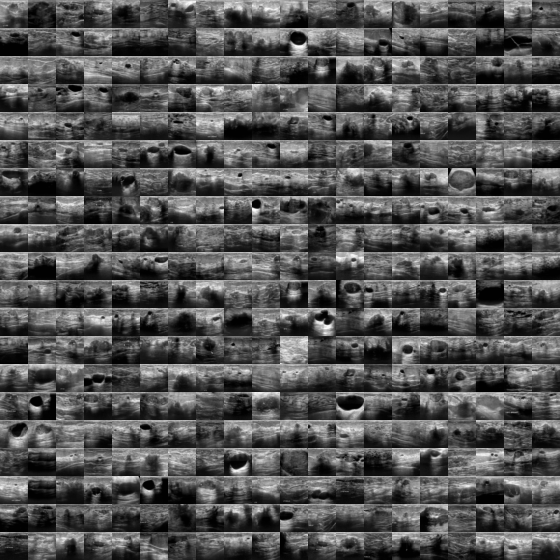

In [21]:
# montage

trainDataset.montage(length=20)

In [22]:
epochs = 20

bestAccuracy = 0
bestParams = {}

# Grid search loop
for lr in hyperParams['learningRate']:
    for batchSize in hyperParams['batchSize']:
        for weightDecay in hyperParams['weightDecay']:
            # Set up training
            model = initialise_model()
            model.to(device)
            optimiser, scheduler, criterion = setUpTraining(model, lr, weightDecay)
            trainLoader, testLoader, valLoader = getDataLoaders(batchSize)

            # Training loop
            for epoch in range(epochs):
                model.train()
                for inputs, targets in trainLoader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    optimiser.zero_grad()
                    outputs = model(inputs)
                    if task == 'multi-label, binary-class':
                        targets = targets.to(torch.float32)
                    else:
                        targets = targets.squeeze().long()
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimiser.step()

            # Evaluation on the test set
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in testLoader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
            accuracy = correct / total

            if accuracy > bestAccuracy:
                bestAccuracy = accuracy
                bestParams = {'learningRate': lr, 'batchSize': batchSize, 'weightDecay': weightDecay}
                torch.save(model.state_dict(), 'best_model.pth')

print(f"Best Hyperparameters: {bestParams} with Test Accuracy: {bestAccuracy:.2f}%")

Best Hyperparameters: {'learningRate': 0.001, 'batchSize': 120, 'weightDecay': 0.01} with Test Accuracy: 68.58%


## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

## Next, we can start to train and evaluate!

In [23]:
bestValAccuracy = 0

for epoch in range(20):
    trainLoss = 0
    trainCorrect = 0
    trainTotal = 0
    valLoss = 0  
    valCorrect = 0
    valTotal = 0

    # Training phase
    model.train()
    for inputs, targets in trainLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimiser.zero_grad()
        outputs = model(inputs)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()

        # Calculate training metrics
        trainLoss += loss.item() * inputs.size(0)  # Multiply loss by batch size
        _, predicted = outputs.max(1)
        trainTotal += targets.size(0)
        trainCorrect += predicted.eq(targets).sum().item()

    trainLoss /= trainTotal  # Average loss over all samples
    trainAccuracy = 100 * trainCorrect / trainTotal  # Convert to percentage

    # Validation phase
    model.eval()
    with torch.no_grad():
        for inputs, targets in valLoader:
            inputs, targets = inputs.to(device), targets.to(device)
    
            # Ensure targets are correctly formatted for CrossEntropyLoss
            if targets.dim() > 1 and targets.size(1) == 1:
                targets = targets.squeeze(1) 
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valLoss += loss.item() * inputs.size(0)  # Accumulate validation loss
    
            _, predicted = outputs.max(1)
            valTotal += targets.size(0)
            valCorrect += predicted.eq(targets).sum().item()
    
    valLoss /= valTotal  # Average validation loss over all samples
    valAccuracy = 100 * valCorrect / valTotal  # Convert to percentage

    if valAccuracy > bestValAccuracy:
        bestValAccuracy = valAccuracy
        torch.save(model.state_dict(), 'model_best.pth')
        print(f'Epoch {epoch}: New best model saved with validation accuracy: {bestValAccuracy:.2f}%')

    # Print training and validation results
    print(f'Epoch {epoch}: Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.2f}%, Validation Loss: {valLoss:.4f}, Validation Accuracy: {valAccuracy:.2f}%')

Epoch 0: New best model saved with validation accuracy: 89.74%
Epoch 0: Train Loss: 0.0921, Train Accuracy: 96.34%, Validation Loss: 0.3517, Validation Accuracy: 89.74%
Epoch 1: Train Loss: 0.0661, Train Accuracy: 97.99%, Validation Loss: 0.3695, Validation Accuracy: 87.18%
Epoch 2: Train Loss: 0.0845, Train Accuracy: 97.07%, Validation Loss: 0.5398, Validation Accuracy: 82.05%
Epoch 3: Train Loss: 0.0765, Train Accuracy: 98.17%, Validation Loss: 0.3901, Validation Accuracy: 87.18%
Epoch 4: Train Loss: 0.0680, Train Accuracy: 97.99%, Validation Loss: 0.3458, Validation Accuracy: 87.18%
Epoch 5: Train Loss: 0.0827, Train Accuracy: 97.07%, Validation Loss: 0.5406, Validation Accuracy: 83.33%
Epoch 6: Train Loss: 0.0757, Train Accuracy: 97.44%, Validation Loss: 0.4522, Validation Accuracy: 82.05%
Epoch 7: Train Loss: 0.0564, Train Accuracy: 98.53%, Validation Loss: 0.4906, Validation Accuracy: 82.05%
Epoch 8: Train Loss: 0.0779, Train Accuracy: 97.99%, Validation Loss: 0.4282, Validation 

In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score

def test(split):
    model.eval()
    y_true = []
    y_prob = []

    # Select the appropriate DataLoader based on the split
    dataLoader = trainLoader if split == 'train' else testLoader

    with torch.no_grad():
        for inputs, targets in dataLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Apply softmax to model outputs to get probabilities
            outputs = outputs.softmax(dim=-1)
            
            # Prepare targets based on task type
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
            else:
                targets = targets.squeeze().long()

            # Collect all targets and output probabilities
            y_true.extend(targets.cpu().numpy())
            y_prob.extend(outputs.cpu().numpy())

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_prob = np.array(y_prob)

        # Calculate metrics
        y_pred = np.argmax(y_prob, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        
        # AUC calculation, handling binary/multiclass via one-vs-rest approach if necessary
        if n_classes == 2:
            auc = roc_auc_score(y_true, y_prob[:, 1])
        else:
            auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

        # Print the results
        print(f'{split} - AUC: {auc:.3f}, Accuracy: {accuracy:.3f}')

print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train - AUC: 0.999, Accuracy: 0.985
test - AUC: 0.896, Accuracy: 0.891


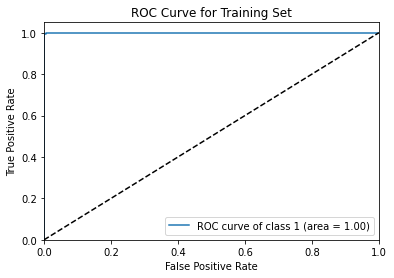

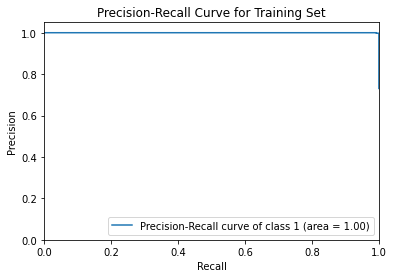

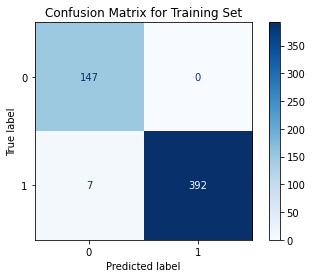

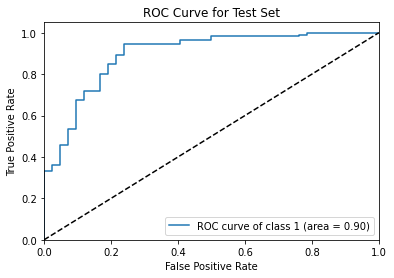

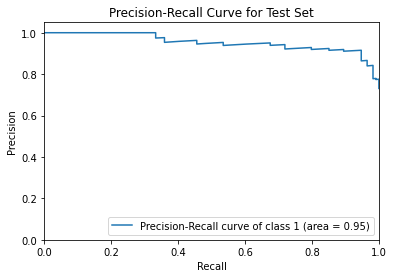

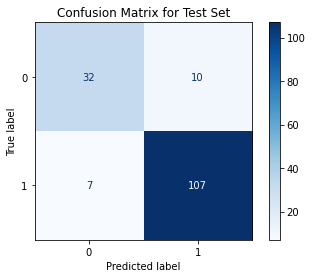

Evaluating on Training Set...

Precision: 1.0000
Recall: 0.9825
F1 Score: 0.9912

Evaluating on Test Set...

Precision: 0.9145
Recall: 0.9386
F1 Score: 0.9264


In [25]:
def evaluateModel(model, dataLoader, device):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for inputs, targets in dataLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.softmax(dim=-1) 
            y_true.extend(targets.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())
    return np.array(y_true), np.array(y_scores)

def plotRocCurve(y_true, y_scores, datasetType):
    fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
    roc_auc_value = sklearn_auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve of class 1 (area = {roc_auc_value:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {datasetType}')
    plt.legend(loc="lower right")
    plt.show()

def plotPrecisionRecallCurve(y_true, y_scores, datasetType):
    # Assuming class '1' is the positive class
    precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])
    averagePrecision = average_precision_score(y_true, y_scores[:, 1])
    
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve of class 1 (area = {averagePrecision:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {datasetType}')
    plt.legend(loc="lower right")
    plt.show()
    
def plotConfusionMatrix(yTrue, yPred, datasetType):
    cm = confusion_matrix(yTrue, yPred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {datasetType}')
    plt.show()

# Configuration of device and model evaluations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_true_train, y_scores_train = evaluateModel(model, trainLoader, device)
y_true_test, y_scores_test = evaluateModel(model, testLoader, device)
y_pred_train = np.argmax(y_scores_train, axis=1)
y_pred_test = np.argmax(y_scores_test, axis=1)

# Plotting and analysis
plotRocCurve(y_true_train, y_scores_train, "Training Set")
plotPrecisionRecallCurve(y_true_train, y_scores_train, "Training Set")
plotConfusionMatrix(y_true_train, y_pred_train, "Training Set")
plotRocCurve(y_true_test, y_scores_test, "Test Set")
plotPrecisionRecallCurve(y_true_test, y_scores_test, "Test Set")
plotConfusionMatrix(y_true_test, y_pred_test, "Test Set")

train_precision_val = precision_score(y_true_train, y_pred_train)
train_recall_val = recall_score(y_true_train, y_pred_train)
train_f1_val = f1_score(y_true_train, y_pred_train)

test_precision_val = precision_score(y_true_test, y_pred_test)
test_recall_val = recall_score(y_true_test, y_pred_test)
test_f1_val = f1_score(y_true_test, y_pred_test)

# Output the calculated metrics
print('Evaluating on Training Set...\n')
print(f"Precision: {train_precision_val:.4f}")
print(f"Recall: {train_recall_val:.4f}")
print(f"F1 Score: {train_f1_val:.4f}")
print('\nEvaluating on Test Set...\n')
print(f"Precision: {test_precision_val:.4f}")
print(f"Recall: {test_recall_val:.4f}")
print(f"F1 Score: {test_f1_val:.4f}")

In [26]:
def validateModel(model, criterion, loader):
    model.eval()
    totalLoss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            if targets.dim() > 1 and targets.size(1) == 1:
                targets = targets.squeeze(1)
            elif targets.dim() > 1: 
                targets = targets.argmax(dim=1) 
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            totalLoss += loss.item()
    return totalLoss / len(loader)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 20
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fullDataset = ConcatDataset([trainDataset, valDataset, testDataset])
fold_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(fullDataset)):
    print(f"\nStarting Fold {fold+1}/{num_folds}\n")
    trainSubset = Subset(fullDataset, train_idx)
    testSubset = Subset(fullDataset, test_idx)

    trainLoader = DataLoader(trainSubset, batch_size=bestParams['batchSize'], shuffle=True)
    testLoader = DataLoader(testSubset, batch_size=bestParams['batchSize'])

    model = initialise_model().to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=bestParams['learningRate'], weight_decay=bestParams['weightDecay'])
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=5)

    for epoch in range(num_epochs):
        model.train()
        totalTrainLoss = 0
        for inputs, targets in trainLoader:
            inputs, targets = inputs.to(device), targets.to(device)
    
            if targets.dim() > 1 and targets.size(1) == 1:
                targets = targets.squeeze(1)
            elif targets.dim() == 1 and targets.dtype == torch.float32:
                targets = torch.argmax(targets, dim=1)
    
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            totalTrainLoss += loss.item()

        valLoss = validateModel(model, criterion, testLoader)
        scheduler.step(valLoss)
    
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for inputs, targets in testLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1]) 

        accuracy = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_scores)

        fold_results.append((accuracy, auc))
        print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

average_accuracy = np.mean([acc for acc, _ in fold_results])
average_auc = np.mean([auc for _, auc in fold_results])
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")
print(f"Average AUC across all folds: {average_auc:.4f}")


Starting Fold 1/5

Fold 1 - Accuracy: 0.8397, AUC: 0.8525

Starting Fold 2/5

Fold 2 - Accuracy: 0.8718, AUC: 0.9049

Starting Fold 3/5

Fold 3 - Accuracy: 0.8269, AUC: 0.8694

Starting Fold 4/5

Fold 4 - Accuracy: 0.8269, AUC: 0.7922

Starting Fold 5/5

Fold 5 - Accuracy: 0.8077, AUC: 0.8638

Average Accuracy across all folds: 0.8346
Average AUC across all folds: 0.8565
